# Creating a simple simulation

- This notebook contains a very simple SIS simulation:
   - The input consists of only one tone
   - The embedding circuit is ignored (no harmonic balance)
   - The DC I-V curve is generated through a polynomial model
   
- The simulation calculates:
   - The DC tunneling current (i.e., the pumped I-V curve)
   - The AC tunneling current

In [1]:
%matplotlib inline

import qmix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Generate response function

- Here we will generate the response function using a polynomial model
- This class will automatically generate the Kramers-Kronig transform of the DC I-V curve, and then setup the interpolation.

Generating response function:
 - Interpolating:
    - DC I-V curve:
       - npts for DC I-V: 273
       - avg. error: 3.7010E-10
       - max. error: 0.0000 at v=-1.10
    - KK curve:
       - npts for KK I-V: 330
       - avg. error: 6.1923E-07
       - max. error: 0.0001 at v=1.11



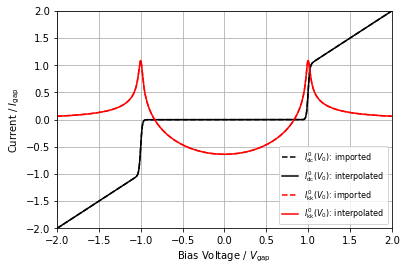

In [2]:
resp = qmix.respfn.RespFnPolynomial(p_order=50)

resp.show_current();

## Define embedding circuit
- The ``EmbeddingCircuit`` class contains all of the information about the embedding circuit. This includes the Thevenin voltage, the Thevening impedance, and the frequency. In this notebook, the embedding impedance is ignored. This means that the AC voltage across the junction is equal to the Thevenin voltage of the embedding circuit.
- Note: 
   - All of the circuit properties are normalized: 
      - voltages are normalized to the gap voltage (``vgap``), 
      - resistances to the normal resistance (``rn``), 
      - currents to the gap current (``igap = vgap / rn``), and 
      - frequencies to the gap frequency (``fgap``).

In [3]:
# create an instance of the embedding circuit class
# this holds all of the data about the embedding circuit (incl. voltage, impedances and frequencies)
cct = qmix.circuit.EmbeddingCircuit()

# set normalised frequency
# (equivalent to the photon voltage (vph))
cct.vph[1] = 0.33

# set Thevenin voltage
cct.vt[1, 1] = 0.33

# calculate AC voltage across junction
vj = qmix.harmonic_balance.harmonic_balance(cct, resp)

Running harmonic balance:
Done.



## Calculate desired tunnelling currents

- Note: 
    - ``qmix.qtcurrent.qtcurrent`` will calculate the quasiparticle tunnelling current based on the voltage across the junction ``vj``, the simulation parameters contained within ``cct``, and the response function ``resp``.
    - The frequency that is solves for is the last argument passed to the junction below. For example, 
       - ``0`` corresponds to the DC quasiparticle tunnelling current
       - ``cct.vph[1]`` corresponds to the AC quasiparticle tunnelling current of the first tone and first harmonic
    - Normally, this is done by passing a list of frequencies that we want to solve for. Here, we select the first current in the list by adding ``[0]`` to the end of the function call

In [4]:
# DC tunneling current
idc = qmix.qtcurrent.qtcurrent(vj, cct, resp, 0)

# AC tunneling current
iac = qmix.qtcurrent.qtcurrent(vj, cct, resp, cct.vph[1])

Calculating tunneling current...
 - 1 tone(s)
 - 1 harmonic(s)
Done.
Time: 0.0069 s

Calculating tunneling current...
 - 1 tone(s)
 - 1 harmonic(s)
Done.
Time: 0.0040 s



## Plot the pumped I-V curve

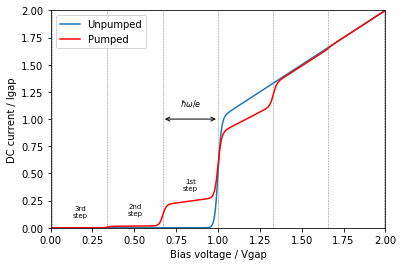

In [5]:
fig, ax = plt.subplots()

# vertical lines for photon steps
for i in range(-10,10):
    ax.axvline(1 - i * cct.vph[1], c='gray', ls='--', lw=0.5)
# plot I-V data
ax.plot(resp.voltage, resp.current, label='Unpumped')
ax.plot(cct.vb, idc, 'r', label='Pumped')
# label the steps
for i, lbl in zip(range(3), ['1st', '2nd', '3rd']):
    vtmp = 1 - (i + 0.5) * cct.vph[1]
    itmp = np.interp(vtmp, cct.vb, idc)
    ax.annotate("{}\nstep".format(lbl), 
                xy=(vtmp, itmp+0.15), 
                xytext=(vtmp, itmp+0.15),
                va='center', ha='center', 
                fontsize=7)
# hw/e label
ax.text(1-cct.vph[1]/2, 1.1, r'$\hbar\omega/e$', fontsize=8, ha='center', va='bottom')
ax.annotate("", xy=(1-cct.vph[1], 1), xytext=(1, 1), 
    arrowprops=dict(arrowstyle="<->", color='k'))
# other labels
ax.set(xlabel='Bias voltage / Vgap', xlim=[0,2])
ax.set(ylabel='DC current / Igap', ylim=[0,2])
ax.legend(frameon=True);

## Plot AC tunneling currents

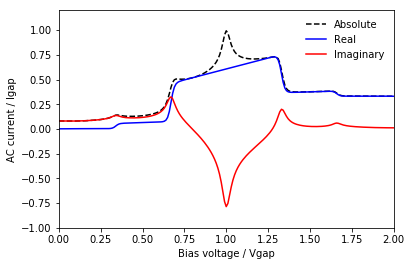

In [6]:
fig, ax = plt.subplots()

ax.plot(cct.vb, np.abs(iac), 'k--', label=r'Absolute')
ax.plot(cct.vb, np.real(iac), 'b', label=r"Real")
ax.plot(cct.vb, np.imag(iac), 'r', label=r"Imaginary")
ax.set(xlabel='Bias voltage / Vgap', xlim=[0,2])
ax.set(ylabel='AC current / Igap', ylim=[-1,1.2])
ax.legend(frameon=False);